# A Demonstration of DiscoCH
## Switzerland's First Operationally Ready National Early Leaf Discoloration Detection Tool

*Trees that experienced early discoloration during the drought year 2018 presented significant physiological stress (Wohlgemuth et al., 2020; Walthert et al., 2021; Frei et al.,
2022), reduced growth (Klesse et al., 2024; Rohner et al., 2021) and increased rates of dieback and mortality (Obladen et al., 2021; Neycken et al., 2024) in the following years*

DiscoCH, developed by the WSL Forest Resources and Managment GIS Group as a part of the FOEN/NFI Funded Project *Drought Assesment in Swiss Forests*, is a remote sensing based early leaf discoloration detection model trained and tested on aproximately 2000 field observations of early leaf discoloration made in Switzerland's European Beech forests between 2017 and 2023.
The model is trained to accurately predict whether trees within a 10 m pixel are seasonaly discolored regardless of disturbance or crown damage from previous years.

***DiscoCH fundamentally simulates a regular field observation of discoloration across all of Switzerland's dominant European Beech forests.***

<figure>
  <img src="../data/examples/Fig_4_FullRes.png" width="80%">
  <figcaption> A) Example Monthly Discoloration Probability in the Canton of Basel-Land. B) Google Earth Comparisons across Switzerland. </figcaption>
</figure>

Additional information on the basis for the DiscoCH model and its historical application can be found at this link: [Bloom et al., in Review](http://dx.doi.org/10.2139/ssrn.5343751)

**This notebook demonstrates an application of DiscoCH to a small area in the Canton of Schaffhausen. We use the historical SwissEO Sentinel-2 Time Series to simulate how discoloration developed over the course of the summer 2018 as if new data was becoming available in near real-time.**

## 1. Notebook Setup
This cell imports DiscoCH tools and other necessary libraries in Google Co-lab

NOTE:
Colab ships with preinstalled ML packages that require numpy>=2.
This project intentionally pins numpy<2 for geospatial compatibility.
Dependency warnings can be ignored but may require a kernel restart.

In [ ]:
# Clone repo
!git clone https://github.com/ckb1oom/DiscoCH.git
repo_path = "/content/DiscoCH"

# Install dependencies
!pip install -r DiscoCH/requirements.txt

# Add the src folder to Python path
import sys
sys.path.append("/content/DiscoCH/src")

In [1]:
# Import scripts
from disco_ch.stac_pull import (
    new_image_check,
    load_minmax_rasters,
    update_vi_min_max,
    pull_closest_from_stac,
    normalize_vis,
    build_template
)
from disco_ch.apply_model_stac import apply_disco
import disco_ch.user_defined_params as udp

# Defines relevant data paths

# STAC endpoint
stac_location = "https://data.geo.admin.ch/api/stac/v0.9/"

# Forest mask location
forest_mask = "DiscoCH/data/DRAINS_Forest_Mask.tif"

# Template raster with NaN extent (same resolution and CRS)
ch_template = "DiscoCH/data/CH_NoValue_255.tif"

# Trained discoloration model
disco_model = "DiscoCH/data/empirical_discoloration_model_pipeline_2025_6_2.pkl"

## 2. User Defined Parameters
Define your dates of interest ('YYYY-MM-DD') for Min-Max Normalization and Model Application (should only include dates within a single year)

In [2]:
start_date = '2018-04-01'
end_date = '2018-08-18'

Define the bounding box of your area of interest in Switzerland

In [3]:
bounding_box = (2691388, 1285780, 2697392, 1290313)  # Region in Schaffhausen

## 3. Check and prepare annual Min-Max Vegetation Indices
This cell checks for min-max data 

In [4]:
items_to_process = new_image_check(
    start_date,
    end_date,
    None,
    stac_location,
)

Found 65 images in 2018
Already processed: 0
New images to process: 65


## 4. Update Min-Max Vegetation Indices and Apply Discoloration Model
This cell updates the min-max vegetation index and runs the discoloration model incrementally as if new Sentinel-2 images were ariving in near real-time

Processing 65 new STAC items

 Processing 1/65 : 2018-04-02t102021
  Created VIs in 0.02 seconds
  No existing VI min or max data was found. Creating new files.
  Initialized annual Min Max from Template in 0.01 seconds
  Compared to existing Min Max in 0.29 seconds
  Min/Max saved + metadata updated in 0.00 seconds
  Running normalization and model application
This asset does not have enough valid pixels to plot

 Processing 2/65 : 2018-04-07t102019
  Created VIs in 0.02 seconds
  Compared to existing Min Max in 0.28 seconds
  Min/Max saved + metadata updated in 0.00 seconds
  Running normalization and model application


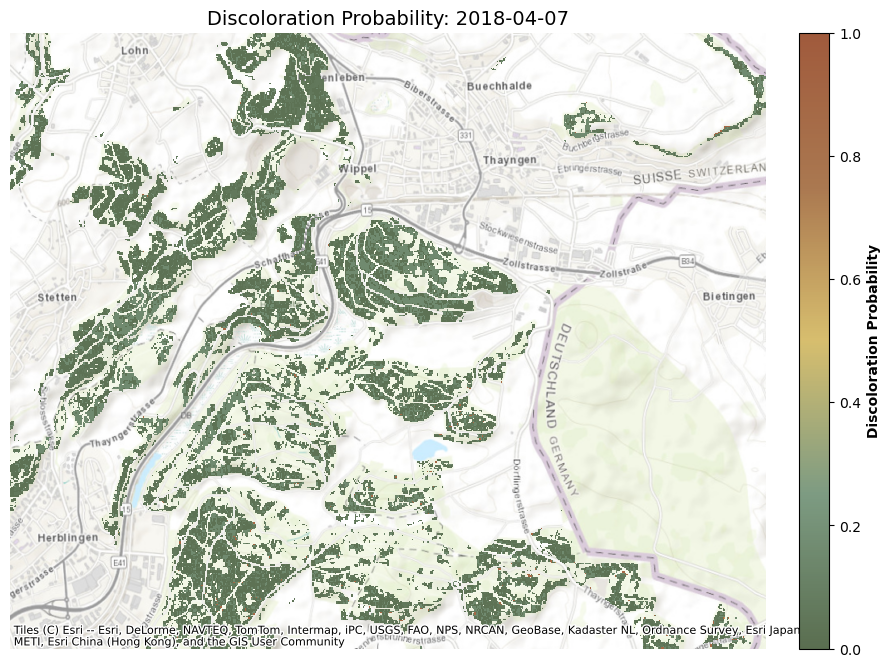


 Processing 3/65 : 2018-04-08t104021
  No data in bbox, skipping asset

 Processing 4/65 : 2018-04-13t104019
  No data in bbox, skipping asset

 Processing 5/65 : 2018-04-14t101019
  No data in bbox, skipping asset

 Processing 6/65 : 2018-04-17t102019
  Created VIs in 0.02 seconds
  Compared to existing Min Max in 0.28 seconds
  Min/Max saved + metadata updated in 0.00 seconds
  Running normalization and model application


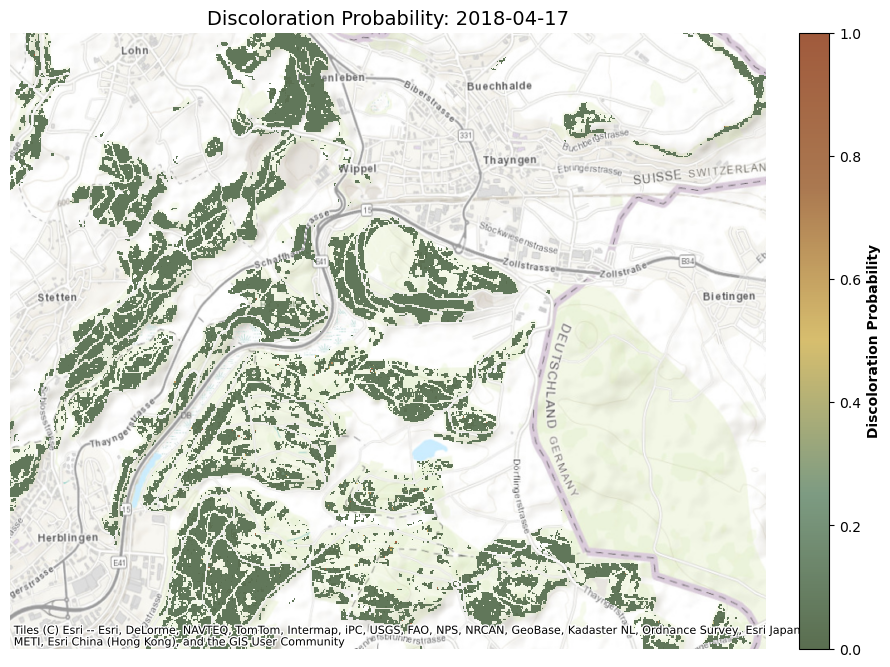


 Processing 7/65 : 2018-04-18t104021
  No data in bbox, skipping asset

 Processing 8/65 : 2018-04-19t101031


KeyboardInterrupt: 

In [5]:
vi_min, vi_max = None, None

print(f"Processing {len(items_to_process)} new STAC items")

template = build_template(ch_template, bounding_box)

year_of_interest = int(start_date.split("-")[0])

update_vi_min_max(
    items_to_process,
    year_of_interest,
    existing_data=None,
    forest_mask=forest_mask,
    template=template,
    bbox=bounding_box,
    run_after_each_update=True,
    disco_model=disco_model,
    output_dir=None
    )